In [3]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

from matplotlib.colors import ListedColormap
%matplotlib inline
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import OneHotEncoder
import sklearn.linear_model
import os.path

import time

from NeuralNet import NeuralNet
from utils.json import *
from utils.nnsetup import *
from utils.attackperformance import *

np.random.seed(1)

In [4]:
X_train, Y_train, Y_train_e, X_test, Y_test = get_datasets()

In [114]:
cls = NeuralNet(layer_dims = [784, 60, 10], learning_rate = 0.1, num_iter = 300,
                normalize = False, mini_batch_size=2048)

cls = getNN("nets/main_nn_300")

In [115]:
Y_train_hat = cls.predict(X_train)
Y_test_hat = cls.predict(X_test)

print(accuracy_score(Y_train, Y_train_hat))
print(accuracy_score(Y_test, Y_test_hat))

0.9702678571428571
0.9580952380952381


## Pixel DP defense

In [ ]:
cls_dp = NeuralNet(layer_dims = [784, 60, 10], learning_rate = 0.1, num_iter = 300,
                     normalize = False, mini_batch_size=2048,
                     noise_layer=1, noise_layer_sensitivity=1, noise_type='Laplacian',
                     attack_size=1, eps=1)

In [ ]:
cls_dp.fit(X_train, Y_train)

In [186]:
cls_dp = getNN("nets/main_nn_300")
cls_dp.noise_layer = 1
cls_dp.noise_layer_sensitivity = 2
cls_dp.noise_type = 'Laplacian'
cls_dp.attack_size = 1
cls_dp.eps=1

In [187]:
cls_dp.num_iter

100

In [188]:
Y_train_hat = cls_dp.predict(X_train)
Y_test_hat = cls_dp.predict(X_test)

print(accuracy_score(Y_train, Y_train_hat))
print(accuracy_score(Y_test, Y_test_hat))

0.20163690476190477
0.2025


In [191]:
cls_dp.n_expected_scores = 40

In [192]:
n = 1000

Y_train_hat = cls_dp.predict(X_train[:n].copy())
Y_test_hat = cls_dp.predict(X_test[:n].copy())

print(accuracy_score(Y_train[:n], Y_train_hat))
print(accuracy_score(Y_test[:n], Y_test_hat))

0.519
0.536


## Attact test

In [169]:
attack = Attack(cls_dp)

In [159]:
cls_dp.n_expected_scores = 10

In [170]:
test_size = 1000
X_test_c = X_test[:test_size].copy()
Y_test_c = Y_test[:test_size].copy()
Y_test_e = np.array([[1 if i == y[0] else 0 for i in range(10)] for y in Y_test_c])

In [171]:
max_iterations = 1
epsilon = 1/255
x_adv = attack.attack_on_dp(X_test_c,
                            Y_test_e,\
                            'FGSM',\
                            max_iterations,\
                            adapting_rate=epsilon, print_cost=False, targeted=False).T

In [173]:
cls_dp.n_expected_scores = 10

In [177]:
np.sum(cls_dp.predict(x_adv).reshape((len(X_test_c), 1)) != Y_test_c)

52

In [164]:
np.sum(L2_norm(x_adv-X_test_c, 1))/len(X_test_c)

0.08717640113425258

In [48]:
Y_test_c.shape

(100, 1)

In [ ]:
def get_insights_dp(classifier, epsilons, X_test_c, Y_test_c, max_iterations=1000, ignore_not_adversarial=False, show_progress=True):
  attack = Attack(classifier)

  df = pd.DataFrame(
      columns=['target', 'successful attempts', 'epsilon'])  # 'initial',
  non_targeted = pd.DataFrame(
      columns=['original', 'prediction', 'iterations', 'epsilon', 'L2 norm'])

  Y_hat_c = classifier.predict(X_test_c)

  tick = time.time()
  # np.arange(50)/255:#, 3/255, 5/255, 10/255, 15/255, 30/255, 50/255, 80/255, 120/255]:#[1/255]:#0.007, 0.01, 0.05, 0.1, 0.2]:
  for epsilon in epsilons:
    print('epsilon =', epsilon)
    total_attempts = 0
    total_iter = 0
    
    x_adv = attack.attack_on_dp(x,
                          np.array([[1 if i == y else 0 for i in range(10)]]),\
                          'FGSM',\
                          max_iterations,\
                          adapting_rate=epsilon, print_cost=False, targeted=False).T[0]

    prediction = classifier.predict(x_adv)
    

    non_targeted = non_targeted.append({'original': y[0], 'prediction': prediction,
                                        'iterations': attack.iter, 'L2 norm': L2_norm(x[0]-x_adv),
                                        'epsilon': epsilon}, ignore_index=True)

    y_hat_adv.append(prediction)

      if(show_progress and total_attempts % (X_test_c.shape[0]//10) == 0):
        print(total_attempts, 'instances,', len(adversarial), 'adversaries')

    print(total_attempts, 'instances,', len(adversarial), 'adversaries')

    print('------------------------------')
    #print('------------------------------',example.shape)
    #Y_hat = classifier.predict(example).reshape(true_label.shape)

    #print((Y_hat == target).shape)
    #print((Y_hat != Y_test) * (Y_hat == target) * ((cls.predict(X_test)==Y_test).reshape(Y_hat.shape)))

    successful_attempts = len(adversarial)  # np.sum(
    #  (Y_hat != true_label)
    #  * (Y_hat == target))
    #* (true_label == cls.predict(X_test_c).reshape(true_label.shape)))

    df = df.append({'successful attempts': successful_attempts,
                    'epsilon': epsilon}, ignore_index=True)

  print('total time:', time.time() - tick)
  print('total iter:', total_iter)
  return df, non_targeted, initial, adversarial, example


In [24]:
test_epsilon = [10/255]
#test_epsilon = [1/255, 3/255, 5/255, 10/255, 15/255, 30/255, 50/255, 80/255, 120/255]
ignore_not_adversarial = False

epsilon = 0.0392156862745098
10 instances, 7 adversaries
20 instances, 14 adversaries
30 instances, 21 adversaries
40 instances, 26 adversaries
50 instances, 33 adversaries
60 instances, 41 adversaries
70 instances, 48 adversaries
80 instances, 57 adversaries
90 instances, 65 adversaries
100 instances, 72 adversaries
100 instances, 72 adversaries
------------------------------
total time: 20.10461163520813
total iter: 243


,target,successful attempts,epsilon
0,NaN,72.0,0.039216


In [26]:
max(insights_dp['iterations'])

6.0

In [16]:
np.sum(cls_dp.predict(adversarial_dp) != cls_dp.predict(initial_dp))

19

In [17]:
n_iter = max(insights_dp['iterations'])
iterations = np.arange(n_iter)
n_iter

52.0

In [18]:
#accuracy = []
accuracy_dp = []
for i in iterations:
  #accuracy.append(1 - sum(insights['iterations']<=i)/insights.shape[0])
  accuracy_dp.append(1 - sum(insights_dp['iterations']<=i)/insights_dp.shape[0])

In [19]:
#distance = []
distance_dp = []
ticks = np.linspace(np.min(insights_dp['L2 norm']), np.max(insights_dp['L2 norm']), 100)
for i in ticks:
  #distance.append(1 - sum(insights['L2 norm']<=i)/insights.shape[0])
  distance_dp.append(1 - sum(insights_dp['L2 norm']<=i)/insights_dp.shape[0])

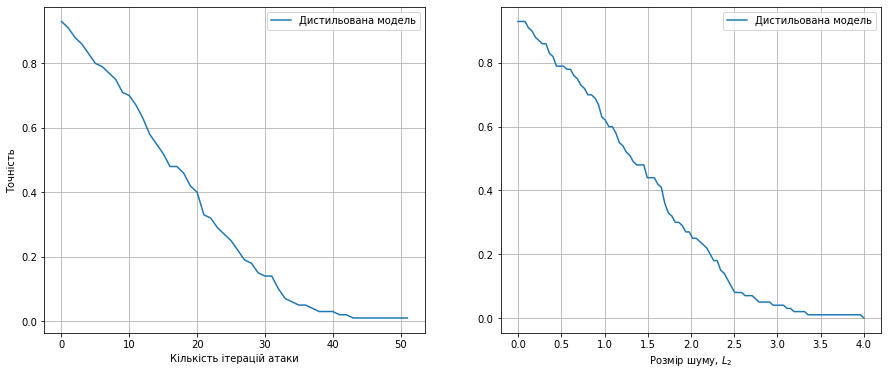

In [20]:
def set_axis(ax):
  ax.set_axisbelow(True)
  ax.grid()
  ax.legend()


fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (15, 6))

#ax1.plot(iterations, accuracy, label='Прообраз')
ax1.plot(iterations, accuracy_dp, label='Дистильована модель')
ax1.set_xlabel('Кількість ітерацій атаки')
ax1.set_ylabel('Точність')
set_axis(ax1)

#ax2.plot(ticks, distance, label='Прообраз')
ax2.plot(ticks, distance_dp, label='Дистильована модель')
ax2.set_xlabel('Розмір шуму, $L_2$')
set_axis(ax2)

plt.savefig("images/distAllT.pdf", bbox_inches = 'tight', pad_inches = 0)

In [ ]:
#save_to_json(cls_dist.parameters, "nets/pixeldp_nn_300"+str(T))